# Analyzing Receptive Fields in Neuropixels Visual Coding Data

## Tutorial overview

One of the most important features of visually responsive neurons is the location and extent of their receptive field. Is it highly localized or spatially distributed? Is it centered on the stimulus display, or is it on an edge? How much does it overlap with the receptive fields of neurons in other regions? Obtaining answers to these questions is a crucial step for interpreting a results related to neurons' visual coding properties.

This Jupyter notebook will cover the following topics:
* <a href='#Receptive-field-mapping-stimulus'>Understanding the receptive field stimulus used in the Neuropixels Visual Coding experiments</a>
* <a href='#Plotting-receptive-fields'>Plotting receptive fields for individual units</a>
* Obtaining pre-computed metrics related to receptive fields (coming soon)
* Finding experiments of interest based on receptive field overlap (coming soon)

This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](./ecephys_data_access.ipynb) first.

Functions related to additional aspects of data analysis will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

Let's start by creating an `EcephysProjectCache` object, and pointing it to a new or existing manifest file:

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

If you're not sure what a manifest file is or where to put it, please check out [this tutorial](./ecephys_data_access.ipynb) before going further.

In [2]:
# Example cache directory path, it determines where downloaded data will be stored
# data_directory = '/local1/ecephys_cache_dir/'
data_directory = 'E:\local\ecephys_cache_dir'

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Let's load the `sessions` table and grab the data for one experiment in the list:

In [3]:
sessions = cache.get_session_table()

print(sessions.index.values[20])

session = cache.get_session_data(sessions.index.values[20])

759883607


## Receptive field mapping stimulus

The `session` object contains all of the spike data for one recording session, as well as information about the stimulus, mouse behavior, and probes.

Because receptive field analysis is so central to interpreting results related to visual coding, every experiment in the Neuropixels Visual Coding dataset includes a standardized receptive field mapping stimulus. This stimulus is always shown at the beginning of the session, and uses the same parameters for every mouse. 

We can look at the `stimulus_presentations` DataFrame in order to examine the parameters of the receptive field mapping stimulus in more detail. The receptive field mapping stimulus consists of drifting Gabor patches with a circular mask, so we're going to filter the DataFrame based on `stimulus_name == 'gabors'`:

In [4]:
session.stimulus_presentations.columns

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

In [6]:
rf_stim_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'gabors']

len(rf_stim_table)

3645

There are 3645 trials for the receptive field mapping stimulus. What combination of stimulus parameters is used across these trials? Let's see which parameters actually vary for this stimulus:

In [7]:
rf_stim_table.keys()

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

In [8]:
rf_stim_table.shape

(3645, 16)

In [9]:
np.unique(rf_stim_table[ 'contrast'])

array([0.8], dtype=object)

In [10]:
rf_stim_table.contrast.unique()

array([0.8], dtype=object)

In [11]:
keys = rf_stim_table.keys()
[key for key in keys if len(np.unique(rf_stim_table[key])) > 1]

['orientation',
 'start_time',
 'stop_time',
 'x_position',
 'y_position',
 'duration',
 'stimulus_condition_id']

We can ignore the parameters related to stimulus timing (`start_time`, `stop_time`, and `duration`), as well as `stimulus_condition_id`, which is used to find presentations with the same parameters. So we're left with `orientation`, `x_position`, and `y_position`.

In [12]:
print('Unique orientations : ' + str(list(np.sort(rf_stim_table.orientation.unique()))))
print('Unique x positions : ' + str(list(np.sort(rf_stim_table.x_position.unique()))))
print('Unique y positions : ' + str(list(np.sort(rf_stim_table.y_position.unique()))))

Unique orientations : [0.0, 45.0, 90.0]
Unique x positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]
Unique y positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]


We have 3 orientations and a 9 x 9 grid of spatial locations. Note that these locations are relative to the center of the screen, not the mouse's center of gaze. How many repeats are there for each condition?

In [13]:
len(rf_stim_table) / (3 * 9 * 9)

15.0

This should match the number we get when dividing the length of the DataFrame by the total number of conditions:

In [14]:
len(rf_stim_table) / len(np.unique(rf_stim_table.stimulus_condition_id))

15.0

What about the drifting grating parameters that don't vary, such as size (in degrees), spatial frequency (in cycles/degree), temporal frequency (in Hz), and contrast?

In [15]:
print('Spatial frequency: ' + str(rf_stim_table.spatial_frequency.unique()[0]))
print('Temporal frequency: ' + str(rf_stim_table.temporal_frequency.unique()[0]))
print('Size: ' + str(rf_stim_table['size'].unique()[0]))
print('Contrast: ' + str(rf_stim_table['contrast'].unique()[0]))

Spatial frequency: 0.08
Temporal frequency: 4.0
Size: [20.0, 20.0]
Contrast: 0.8


This stimulus is designed to drive neurons reliably across a wide variety of visual areas. Because of the large size (20 degree diameter), it lacks spatial precision. It also cannot be used to map on/off subfields on neurons. However, this is a reasonable compromise to allow us to map receptive fields with high reliability across all visual areas we're recording from.

Now that we have a better understanding of the stimulus, let's look at receptive fields for some neurons.

In [16]:
rf_stim_table.keys()

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

## Plotting receptive fields

In order to visualize receptive fields, we're going to use a function in the `ReceptiveFieldMapping` class, one of the stimulus-specific analysis classes in the AllenSDK. Let's import it and create a `rf_mapping` object based on the `session` we loaded earlier:

In [17]:
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping import ReceptiveFieldMapping

rf_mapping = ReceptiveFieldMapping(session)

The `rf_mapping` object contains a variety of methods related to receptive field mapping. Its `stim_table` property holds the same DataFrame we created earlier.

In [18]:
rf_mapping.stim_table

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,
1,0.8,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.804349,0,gabors,85.037870,4,-10,-40,0.233521,1
2,0.8,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.037870,0,gabors,85.288070,4,30,40,0.250201,2
3,0.8,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.288070,0,gabors,85.538271,4,0,0,0.250201,3
4,0.8,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.538271,0,gabors,85.788472,4,-20,20,0.250201,4
5,0.8,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.788472,0,gabors,86.038686,4,-40,40,0.250214,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,0.8,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,995.598539,0,gabors,995.848745,4,30,-10,0.250206,175
3642,0.8,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,995.848745,0,gabors,996.098950,4,30,10,0.250206,228
3643,0.8,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,996.098950,0,gabors,996.349156,4,30,-20,0.250206,156


Before we calculate any receptive fields, let's find some units in primary visual cortex (VISp) that are likely to show clear receptive fields:

In [19]:
v1_units = session.units[session.units.ecephys_structure_acronym == 'VISp']

Now, calculating the receptive field is as simple as calling `get_receptive_field()` with a unit ID as the input argument.

In [20]:
RF = rf_mapping.get_receptive_field(v1_units.index.values[3])

E:\download_files\anaconda_app\envs\env_py_362\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(0, 1)], with a maximum overlap of 0.015479378234388719 seconds.
  warnings.warn("You've specified some overlapping time intervals "


This method creates a 2D histogram of spike counts at all 81 possible stimulus locations, and outputs it as a 9 x 9 matrix. It's summing over all orientations, so each pixel contains the spike count across 45 trials.
 
To plot it, just display it as an image. The matrix is already in the correct orientation so that it matches the layout of the screen (e.g., the upper right pixel contains the spike count when the Gabor patch was in the upper right of the screen).

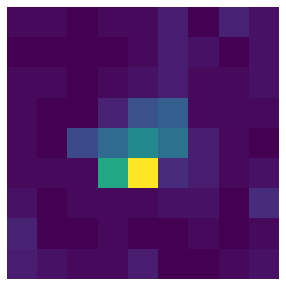

In [21]:
plt.figure(figsize=(5,5))
_ = plt.imshow(RF)
_ = plt.axis('off')

This particular unit has a receptive field that's more or less in the center of the screen.

Let's plot the receptive fields for all the units in V1:

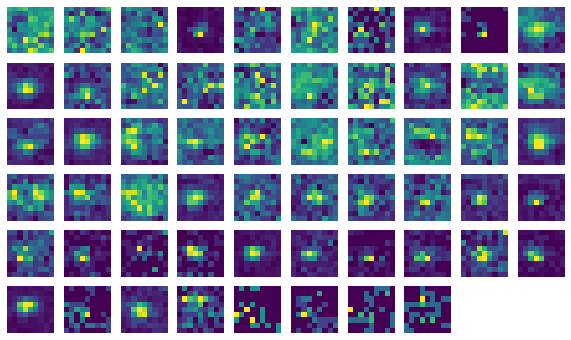

In [22]:
def plot_rf(unit_id, index):
    RF = rf_mapping.get_receptive_field(unit_id)
    _ = plt.subplot(6,10,index+1)
    _ = plt.imshow(RF)
    _ = plt.axis('off')
    
_ = plt.figure(figsize=(10,6))
_ = [plot_rf(RF, index) for index, RF in enumerate(v1_units.index.values)]